In [1]:
import torch
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
LEARNING_RATE = 1e-4
BATCH_SIZE = 16

### __Creating the dataset__

In [3]:
class KeyPointsDataset(Dataset):
    def __init__(self, img_dir, data_file):
        self.img_dir = img_dir
        with open(data_file, 'r') as f:
            self.data = json.load(f)

        self.transforms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.450, 0.410], std=[0.230, 0.225, 0.225])
        ])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data[index]
        img = cv2.imread(f"{self.img_dir}/{item['id']}.png")
        h,w = img.shape[:2]

        img =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.transforms(img)
        keypoints = np.array(item['kps']).flatten()
        keypoints = keypoints.astype(np.float32)

        keypoints[::2] *= 224.0/w # Adjusting the x coordinates
        keypoints[1::2] *= 224.0/h # Adjusting the y coordinates

        return img, keypoints


In [4]:
train_ds = KeyPointsDataset('tennis_court_det_dataset/data/images', 'tennis_court_det_dataset/data/data_train.json')
val_ds = KeyPointsDataset('tennis_court_det_dataset/data/images', 'tennis_court_det_dataset/data/data_val.json')

train_loader = DataLoader(dataset=train_ds,
                          batch_size=BATCH_SIZE,
                          )
val_loader = DataLoader(dataset=val_ds,
                        batch_size=BATCH_SIZE,
                        )

### __Using a pre-trained model__

In [5]:
model = models.resnet101(pretrained=True)

c:\Users\jmuri\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jmuri\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


We need to add a Fully-Connected layer to predict the X and Y coordinates of the court keypoints

In [6]:
model.fc = torch.nn.Linear(model.fc.in_features, 2*14) # Tennsi courts have 14 keypoints and each points has X and Y coordinates
model = model.to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Now we have to train the model

- Loss function and optimizer

In [7]:
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

- Training loop

In [8]:
def train_model(model, optimizer, loss_function, train_loader, valid_loader, epochs, filename):

  valid_loss_min = np.inf

  # Store data to further loss analysis
  train_loss_list = []
  valid_loss_list = []
  best_epoch = 0

  for i in range(epochs):
    # Set model in training mode
    model.train()

    # Set initial losses values to zero
    train_loss = 0.0
    valid_loss = 0.0

    # =================================================================== #
    #                              TRAINING                               #
    # =================================================================== #

    for imgs, kps in train_loader:

        # -----------Send data and targets to GPU-----------
        imgs = imgs.to(device)
        kps = kps.to(device)

        # -----------Set optimizer to zero in each iteration-----------
        optimizer.zero_grad()


        # -----------Take the output of the model-----------
        # Final Model Output
        preds = model(imgs)
        preds = preds.squeeze(dim=1)

        # -----------Compute loss---- -------
        t_loss = loss_function(preds, kps)

        # -----------Perform backpropagation-----------
        t_loss.backward()

        # -----------Perform an optmization step-----------
        optimizer.step()

        # -----------Update cummulative training loss-----------
        train_loss += t_loss.item()*imgs.size(0)

    # Get the epoch's training loss
    train_loss = train_loss/len(train_loader.dataset)
    train_loss_list.append(train_loss)

    # =================================================================== #
    #                              VALIDATION                             #
    # =================================================================== #

    # Set model in evaluation mode
    model.eval()

    # Disable gradient computation
    with torch.no_grad():
      for imgs, kps in valid_loader:

        # -----------Send data and targets to GPU-----------
        imgs = imgs.to(device)
        kps = kps.to(device)

        # -----------Take the output of the model-----------
        # Final model prediction
        output = model(imgs)
        output = output.squeeze(dim=1)

        # -----------Update cummulative validation loss-----------
        v_loss= loss_function(output, kps)
        valid_loss += v_loss.item()*imgs.size(0)

      # Get the epoch's validation loss
      valid_loss = valid_loss/len(valid_loader.dataset)
      valid_loss_list.append(valid_loss)

      # Print epoch's losses
      print(f'Epoch: {i} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

      # Save current model state if its performance was better during the epoch
      if valid_loss <= valid_loss_min:
          print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
          torch.save(model.state_dict(), filename)
          valid_loss_min = valid_loss
          best_epoch = i

  return train_loss_list, valid_loss_list, valid_loss_min, best_epoch

In [9]:
train_loss_list, valid_loss_list, valid_loss_min, best_epoch = train_model(model=model,
                                                                            optimizer=optimizer,
                                                                            loss_function=loss_function,
                                                                            train_loader=train_loader,
                                                                            valid_loader=val_loader,
                                                                            epochs=EPOCHS,
                                                                            filename='KeyPointsModel.pt')

Epoch: 0 	Training Loss: 7969.714828 	Validation Loss: 2364.893731
Validation loss decreased (inf --> 2364.893731).  Saving model ...
Epoch: 1 	Training Loss: 1126.116924 	Validation Loss: 343.199381
Validation loss decreased (2364.893731 --> 343.199381).  Saving model ...
Epoch: 2 	Training Loss: 96.872473 	Validation Loss: 59.552628
Validation loss decreased (343.199381 --> 59.552628).  Saving model ...
Epoch: 3 	Training Loss: 48.146308 	Validation Loss: 44.721024
Validation loss decreased (59.552628 --> 44.721024).  Saving model ...
Epoch: 4 	Training Loss: 37.742578 	Validation Loss: 49.696826
Epoch: 5 	Training Loss: 30.301139 	Validation Loss: 33.677738
Validation loss decreased (44.721024 --> 33.677738).  Saving model ...
Epoch: 6 	Training Loss: 21.820176 	Validation Loss: 23.306410
Validation loss decreased (33.677738 --> 23.306410).  Saving model ...
Epoch: 7 	Training Loss: 16.640146 	Validation Loss: 24.060220
Epoch: 8 	Training Loss: 13.814700 	Validation Loss: 25.975407


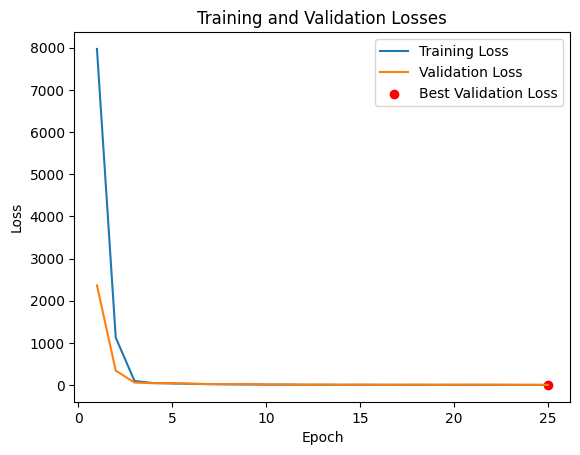

In [10]:
plt.plot(range(1, EPOCHS + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), valid_loss_list, label='Validation Loss')
plt.scatter(best_epoch + 1, valid_loss_min, color='red', label='Best Validation Loss')  # Mark the best point
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()